# Data Vault Demo

The basic concept of the Data Vault is that when a user authenticates themself, they receive an engine that gives them access to all the data (rows, columns, tables, schema, etc.) for which they are authorized.  Users who can authenticate themselves for multiple roles can use those roles simultaneously.  We are keeping in mind the importance of Data Lineage Management (tracked by issue https://github.com/os-climate/os_c_data_commons/issues/50) but is not treated as part of this particular prototype.

The steps of this demo are:

1. Authenticate and acquire three SQLAlchemy engines
    1. Dev engine sees all
    2. Quant engine can do temp scoring but not see fundamental company info
    3. User engine can use temp scoring but not see cumulative emissions nor overshoot info
2. With Dev engine, construct Vaults for:
    1. Fundamental corporate financial information
    2. Corporate emissions data (base year, historical)
    3. Corporate target data (start year, end year, target start value, target end value)
    4. Sector benchmark data (production, CO2e intensity)
3. Dev Engine: Visualize projected emissions (targets and trajectories) and calculate cumulative emissions
4. Quant Engine: Using calculated cumulative emmisions, visualize per-company trajectory and target temperature scores
5. User Engine: Using consensus probability scoring and own portfolio data (ISIN, position value)
    1. Calculate publishable per-company temperature alignment score
    2. Based on aggregate corporate and portfolio information, produce weighting scores to yield overall portfolio alignment score

In [1]:
import os
import pathlib
from dotenv import load_dotenv

# Load some standard environment variables from a dot-env file, if it exists.
# If no such file can be found, does not fail, and so allows these environment vars to
# be populated in some other way
dotenv_dir = os.environ.get('CREDENTIAL_DOTENV_DIR', os.environ.get('PWD', '/opt/app-root/src'))
dotenv_path = pathlib.Path(dotenv_dir) / 'credentials.env'
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path=dotenv_path,override=True)

import trino
from sqlalchemy.engine import create_engine

### Step 1: Initialize Vaut user 'Dev', which has full visibility into corporate financial, production, and target data

In [2]:
sqlstring = 'trino://{user}@{host}:{port}/'.format(
    user = os.environ['TRINO_USER_USER1'],
    host = os.environ['TRINO_HOST'],
    port = os.environ['TRINO_PORT']
)
sqlargs = {
    'auth': trino.auth.JWTAuthentication(os.environ['TRINO_PASSWD_USER1']),
    'http_scheme': 'https',
    'catalog': 'osc_datacommons_dev',
    'schema': 'demo',
}

ingest_catalog = 'osc_datacommons_dev'
ingest_schema = 'demo'

engine_dev = create_engine(sqlstring, connect_args = sqlargs)
print("connecting with engine " + str(engine_dev))
connection_dev = engine_dev.connect()
engine_dev.execute(f"show tables in {ingest_schema}").fetchall()

connecting with engine Engine(trino://os-climate-user1@trino-secure-odh-trino.apps.odh-cl1.apps.os-climate.org:443/)


[('benchmark_ei',),
 ('benchmark_prod',),
 ('cat',),
 ('company_data',),
 ('cumulative_emissions',),
 ('data_vault',),
 ('demo_metastore',),
 ('emissions_data',),
 ('gleif_isin_lei',),
 ('gppd',),
 ('intensity_data',),
 ('isic_to_sector',),
 ('lei_isin',),
 ('my_big_tbl_1',),
 ('odsc_isin_reduction',),
 ('odsc_isin_reduction_notebook',),
 ('odsc_isin_reduction_notebook_pipeline1',),
 ('odsc_rocks',),
 ('odsc_roxx',),
 ('odsc_xxx',),
 ('osc_mlcop',),
 ('osc_rocks',),
 ('parquet_partitions_tutorial',),
 ('production_data',),
 ('pudl_1995_al',),
 ('test3',),
 ('trajectory_data',),
 ('zztop',)]

### The ITR module provides Vault objects that coordinate the interaction of Dev, Quant, and User roles.

The SQLAlchemy engines mediate the actual interaction with the Data Vault.

In [3]:
import json
import os
import pandas as pd
from numpy.testing import assert_array_equal
import ITR

# from ITR.portfolio_aggregation import PortfolioAggregationMethod
# from ITR.temperature_score import TemperatureScore
# from ITR.configs import ColumnsConfig, TemperatureScoreConfig
# from ITR.data.data_warehouse import DataWarehouse
from ITR.data.vault_providers import VaultCompanyDataProvider, VaultProviderProductionBenchmark, \
    VaultProviderIntensityBenchmark, DataVaultWarehouse
# from ITR.interfaces import ICompanyData, EScope, ETimeFrames, PortfolioCompany, IEmissionIntensityBenchmarkScopes, \
#     IProductionBenchmarkScopes
from ITR.interfaces import EScope, IProductionBenchmarkScopes, IEmissionIntensityBenchmarkScopes

### Step 2: construct vaults for corporate financial, production, and target information.

We also create benchmark data (which is presumed public information).  There's more work to be done to modularly add new benchmarks that automatically become available options to to the ITR tool.

In this demo we read ITR benchmark data from JSON files (REST API-friendly).  Such data coming from the notebook filesystem is "untethered" data.  The corporate data comes from an existing data pipeline (in this case, the pipeline processing RMI data).  When data comes from the data commons, it is "tethered" to the Data Commons.  The Data Vault can only control access to data that goes through the Data Commons via 'engines'.

In [4]:
root = os.path.dirname(os.path.abspath("/opt/app-root/src/ITR/test/inputs"))
benchmark_prod_json = os.path.join(root, "inputs", "json", "benchmark_production_OECM.json")
benchmark_EI_json = os.path.join(root, "inputs", "json", "benchmark_EI_OECM.json")

# load production benchmarks
with open(benchmark_prod_json) as json_file:
    parsed_json = json.load(json_file)
prod_bms = IProductionBenchmarkScopes.parse_obj(parsed_json)
vault_production_bm = VaultProviderProductionBenchmark(engine=engine_dev, benchmark_name="benchmark_prod", production_benchmarks=prod_bms)

# load intensity benchmarks
with open(benchmark_EI_json) as json_file:
    parsed_json = json.load(json_file)
ei_bms = IEmissionIntensityBenchmarkScopes.parse_obj(parsed_json)
vault_EI_bm = VaultProviderIntensityBenchmark(engine=engine_dev, benchmark_name="benchmark_ei", EI_benchmarks=ei_bms)

# load company data
# TODO: Pandas reads null data mixed with integers as float64 (np.nan).  This can be fixed post hoc with astype('Int16')
vault_company_data = VaultCompanyDataProvider(engine=engine_dev, company_table="company_data")

vault_warehouse = DataVaultWarehouse(engine_dev, vault_company_data, vault_production_bm, vault_EI_bm)

[(True,)]
[(True,)]


### Step 3: Visualize Emissions, Targets, and Trajectories

SuperSet Dashboard here: https://superset-secure-odh-superset.apps.odh-cl1.apps.os-climate.org/superset/dashboard/17/?native_filters=%28%29

Plot emissions data.  Others can be plotted by following same pattern.

In [5]:
df = pd.read_sql_table(f"emissions_data", engine_dev)

In [6]:
df = df.sort_values(['company_name', 'year']).reset_index(drop=True)

<AxesSubplot:xlabel='year'>

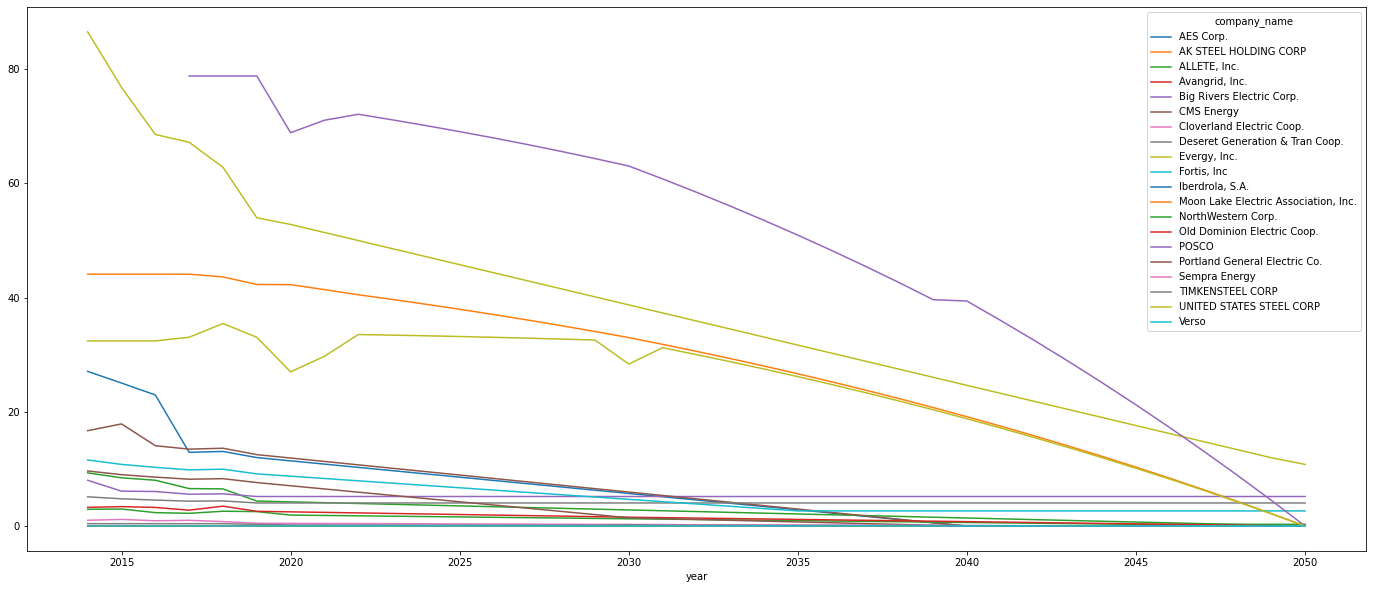

In [7]:
plottable_df = df[~df.company_lei.isin(['SJ7XXD41SQU3ZNWUJ746','5493008F4ZOQFNG3WN54','XRZQ5S7HYJFPHJ78L959', '549300K5VIUTJXQL7X75', 'OZ8GM8L4AHPKSWZMW205',
                                        '1B4S6S7G0TW5EE83BO58', '5493002H80P81B3HXL31', '549300K5VIUTJXQL7X75'])].pivot(index='year', columns='company_name', values='co2_target_by_year').reset_index()

# Must plot the first few columns, but then plot 1/3rd of the companies so as not to over-clutter the graph
plottable_df.iloc[:, [x for x in list(range(0,3)) + list(range(3,93,5))]].plot(x='year', kind='line', figsize=(24,10))

### Step 4: Use Quant engine to access and visualize temperature scores

In [8]:
sqlstring = 'trino://{user}@{host}:{port}/'.format(
    user = os.environ['TRINO_USER_USER2'],
    host = os.environ['TRINO_HOST'],
    port = os.environ['TRINO_PORT']
)
sqlargs = {
    'auth': trino.auth.JWTAuthentication(os.environ['TRINO_PASSWD_USER2']),
    'http_scheme': 'https',
    'catalog': 'osc_datacommons_dev',
    'schema': 'demo',
}

ingest_catalog = 'osc_datacommons_dev'
ingest_schema = 'demo'

engine_quant = create_engine(sqlstring, connect_args = sqlargs)
print("connecting with engine " + str(engine_quant))
connection_quant = engine_quant.connect()

connecting with engine Engine(trino://os-climate-user2@trino-secure-odh-trino.apps.odh-cl1.apps.os-climate.org:443/)


Show that we *cannot* access fundamental company data (cannot show until op1st team changes permissions)

Show that we *can* access both cumulative emissions (input) and temperature scores (output)

In [9]:
temp_score_df = pd.read_sql_table(f"temperature_scores", engine_quant)

In [10]:
temp_score_df.head()

,company_name,company_id,source,scope,benchmark,trajectory_temperature_score,target_temperature_score
0,Public Service Enterprise Group,US7445731067,demo,S1+S2,benchmark_1,1.726799,1.869444
1,WORTHINGTON INDUSTRIES INC,US9818111026,demo,S1+S2,benchmark_1,1.285214,1.285214
2,COMMERCIAL METALS CO,US2017231034,demo,S1+S2,benchmark_1,1.341723,1.304555
3,AES Corp.,US00130H1059,demo,S1+S2,benchmark_1,2.874460,2.433496
4,"Fortis, Inc",CA3495531079,demo,S1+S2,benchmark_1,3.152616,2.184698


In [11]:
plottable_df = temp_score_df[['company_name', 'trajectory_temperature_score', 'target_temperature_score']].sort_values('company_name').set_index('company_name').T

In [12]:
plottable_df

company_name,AES Corp.,AK STEEL HOLDING CORP,"ALLETE, Inc.",Algonquin Power & Utilities Corp.,Alliant Energy,Ameren Corp.,"American Electric Power Co., Inc.","Avangrid, Inc.",Avista Corp.,CARPENTER TECHNOLOGY CORP,...,Public Service Enterprise Group,STEEL DYNAMICS INC,Sempra Energy,Southern Co.,TENARIS SA,TIMKENSTEEL CORP,UNITED STATES STEEL CORP,WEC Energy Group,WORTHINGTON INDUSTRIES INC,"Xcel Energy, Inc."
trajectory_temperature_score,2.874460,2.400967,2.540841,2.440054,2.211943,2.113541,2.566781,1.317737,1.883611,1.624396,...,1.726799,1.337862,1.422185,2.271201,1.517871,1.318847,1.660977,2.539351,1.285214,2.289638
target_temperature_score,2.433496,1.917830,2.194297,2.762842,1.903195,1.957490,2.352981,1.278198,2.069748,1.451154,...,1.869444,1.308582,1.367042,2.186023,1.517871,1.293037,1.487996,2.523781,1.285214,1.767726


<AxesSubplot:>

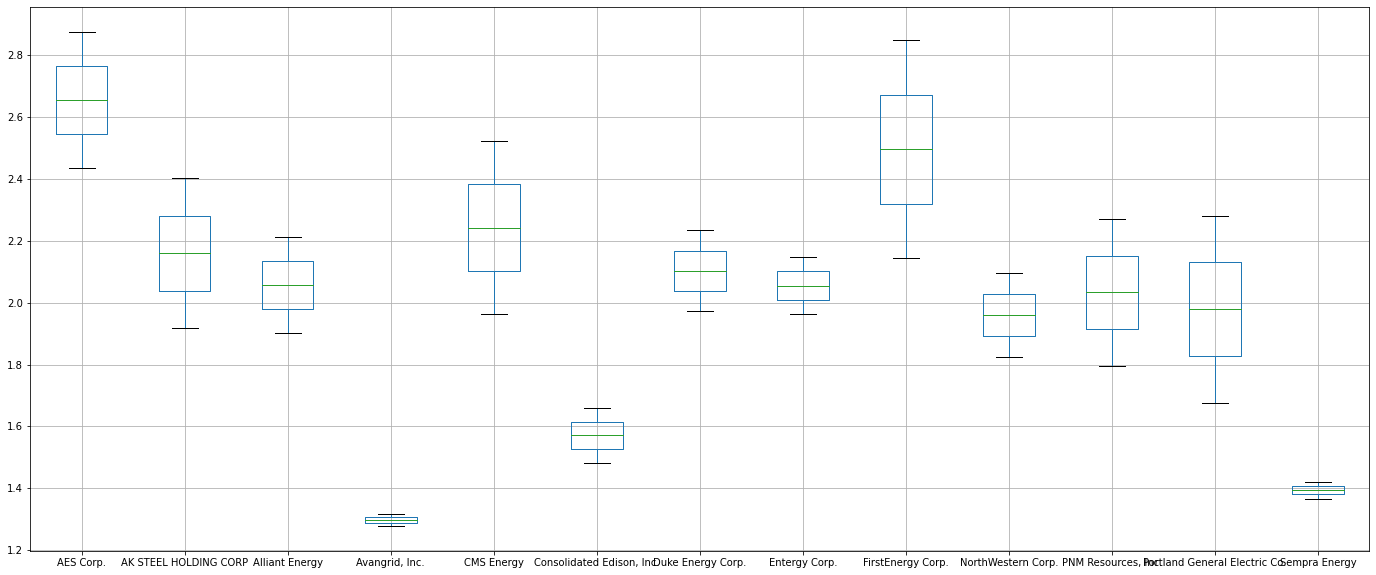

In [13]:
# Must plot the first few columns, but then plot 1/3rd of the companies so as not to over-clutter the graph
plottable_df.iloc[:, [x for x in list(range(0,2)) + list(range(4,35,3))]].boxplot(figsize=(24,10))

### Step 5: Show per-company temperature score and weighted portfolio alignment score

Portfolio weighting scores (which ultimately influence portfolio alignment score) include:
* WATS (size of portfolio company positions used as weights)
* TETS (size of total emissions of portfolio companies used as weights)
* Financial fundamental weights:
    * Market Cap
    * Enterprise Value
    * Assets
    * Revenues

We can pass a list of company IDs to the Data Vault to get back a sum without exposing granular data

In [14]:
sqlstring = 'trino://{user}@{host}:{port}/'.format(
    user = os.environ['TRINO_USER_USER3'],
    host = os.environ['TRINO_HOST'],
    port = os.environ['TRINO_PORT']
)
sqlargs = {
    'auth': trino.auth.JWTAuthentication(os.environ['TRINO_PASSWD_USER3']),
    'http_scheme': 'https',
    'catalog': 'osc_datacommons_dev',
    'schema': 'demo',
}

ingest_catalog = 'osc_datacommons_dev'
ingest_schema = 'demo'

engine_user = create_engine(sqlstring, connect_args = sqlargs)
print("connecting with engine " + str(engine_user))
connection_user = engine_user.connect()

connecting with engine Engine(trino://os-climate-user3@trino-secure-odh-trino.apps.odh-cl1.apps.os-climate.org:443/)


Show that we *cannot* access fundamental company data (cannot show until op1st team changes permissions)

Show that we *can* access both cumulative emissions (input) and temperature scores (output)

In [15]:
portfolio_df = pd.read_csv("data/rmi-20211120-portfolio.csv", encoding="iso-8859-1", sep=';', index_col='company_id')
portfolio_df.head()

,company_name,company_lei,investment_value
company_id,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,3829481
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812


### Calculate portfolio alignment temperature score based on WATS

We can do this with information exclusive to the user space (and the probability-adjusted temperature scores)

In [16]:
# PA_SCORE means "Probability-Adjusted" Temperature Score
portfolio_df['pa_score'] = vault_warehouse.get_pa_temp_scores(probability=0.5, company_ids=portfolio_df.index.values)

In [17]:
portfolio_df.head()

,company_name,company_lei,investment_value,pa_score
company_id,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252,2.653978
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185,2.601448
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,3829481,2.367569
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481,2.057569
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812,2.035515


In [18]:
weight_for_WATS = portfolio_df['investment_value'].sum()
weight_for_WATS

707454890

In [19]:
portfolio_df['WATS_weight'] = portfolio_df['pa_score'] * (portfolio_df['investment_value'] / weight_for_WATS)
portfolio_df.head()

,company_name,company_lei,investment_value,pa_score,WATS_weight
company_id,,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252,2.653978,0.016323
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185,2.601448,0.008193
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,3829481,2.367569,0.012816
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481,2.057569,0.011138
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812,2.035515,0.045799


In [20]:
print(f"Portfolio temperature score based on WATS = {portfolio_df['WATS_weight'].sum()}")

Portfolio temperature score based on WATS = 1.6523262430797563


### Calculate portfolio alignment temperature score based on TETS

We need to carefully meld portfolio data with corp fundamental data (in this case, emissions)

In [21]:
portfolio_df['TETS_weight'] = vault_company_data.compute_portfolio_weights(portfolio_df['pa_score'], 2019, 'emissions', EScope.S1S2)
portfolio_df.head()

,company_name,company_lei,investment_value,pa_score,WATS_weight,TETS_weight
company_id,,,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252,2.653978,0.016323,0.041646
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185,2.601448,0.008193,0.125123
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,3829481,2.367569,0.012816,0.013576
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481,2.057569,0.011138,0.029829
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812,2.035515,0.045799,0.077954


In [22]:
print(f"Portfolio temperature score based on TETS = {portfolio_df['TETS_weight'].sum()}")

Portfolio temperature score based on TETS = 2.257638350627624


In [23]:
portfolio_df['MOTS_weight'] = vault_company_data.compute_portfolio_weights(portfolio_df['pa_score'], 2019, 'company_market_cap', EScope.S1S2)
portfolio_df.head()

,company_name,company_lei,investment_value,pa_score,WATS_weight,TETS_weight,MOTS_weight
company_id,,,,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252,2.653978,0.016323,0.041646,0.043874
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185,2.601448,0.008193,0.125123,NaN
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,3829481,2.367569,0.012816,0.013576,0.015430
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481,2.057569,0.011138,0.029829,0.036299
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812,2.035515,0.045799,0.077954,0.056895


In [24]:
print(f"Portfolio temperature score based on MOTS = {portfolio_df['MOTS_weight'].sum()}")

Portfolio temperature score based on MOTS = 1.9793715406044958


In [25]:
portfolio_df['EOTS_weight'] = vault_company_data.compute_portfolio_weights(portfolio_df['pa_score'], 2019, 'company_enterprise_value', EScope.S1S2)
portfolio_df.head()

,company_name,company_lei,investment_value,pa_score,WATS_weight,TETS_weight,MOTS_weight,EOTS_weight
company_id,,,,,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252,2.653978,0.016323,0.041646,0.043874,0.026506
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185,2.601448,0.008193,0.125123,NaN,NaN
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,3829481,2.367569,0.012816,0.013576,0.015430,0.013646
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481,2.057569,0.011138,0.029829,0.036299,0.037641
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812,2.035515,0.045799,0.077954,0.056895,0.054894


In [26]:
print(f"Portfolio temperature score based on EOTS = {portfolio_df['EOTS_weight'].sum()}")

Portfolio temperature score based on EOTS = 2.106844694461046


In [27]:
portfolio_df['ECOTS_weight'] = vault_company_data.compute_portfolio_weights(portfolio_df['pa_score'], 2019, 'company_evic', EScope.S1S2)
portfolio_df.head()

,company_name,company_lei,investment_value,pa_score,WATS_weight,TETS_weight,MOTS_weight,EOTS_weight,ECOTS_weight
company_id,,,,,,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252,2.653978,0.016323,0.041646,0.043874,0.026506,0.048056
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185,2.601448,0.008193,0.125123,NaN,NaN,NaN
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,3829481,2.367569,0.012816,0.013576,0.015430,0.013646,0.015689
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481,2.057569,0.011138,0.029829,0.036299,0.037641,0.036371
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812,2.035515,0.045799,0.077954,0.056895,0.054894,0.056979


In [28]:
print(f"Portfolio temperature score based on ECOTS = {portfolio_df['ECOTS_weight'].sum()}")

Portfolio temperature score based on ECOTS = 1.971071882709424


In [29]:
portfolio_df['AOTS_weight'] = vault_company_data.compute_portfolio_weights(portfolio_df['pa_score'], 2019, 'company_total_assets', EScope.S1S2)
portfolio_df.head()

,company_name,company_lei,investment_value,pa_score,WATS_weight,TETS_weight,MOTS_weight,EOTS_weight,ECOTS_weight,AOTS_weight
company_id,,,,,,,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252,2.653978,0.016323,0.041646,0.043874,0.026506,0.048056,0.066323
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185,2.601448,0.008193,0.125123,NaN,NaN,NaN,0.021100
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,3829481,2.367569,0.012816,0.013576,0.015430,0.013646,0.015689,0.009641
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481,2.057569,0.011138,0.029829,0.036299,0.037641,0.036371,0.025521
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812,2.035515,0.045799,0.077954,0.056895,0.054894,0.056979,0.043740


In [30]:
print(f"Portfolio temperature score based on AOTS = {portfolio_df['AOTS_weight'].sum()}")

Portfolio temperature score based on AOTS = 1.9949225831738602


In [31]:
portfolio_df['ROTS_weight'] = vault_company_data.compute_portfolio_weights(portfolio_df['pa_score'], 2019, 'company_revenue', EScope.S1S2)
portfolio_df.head()

,company_name,company_lei,investment_value,pa_score,WATS_weight,TETS_weight,MOTS_weight,EOTS_weight,ECOTS_weight,AOTS_weight,ROTS_weight
company_id,,,,,,,,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,4351252,2.653978,0.016323,0.041646,0.043874,0.026506,0.048056,0.066323,0.098889
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,2228185,2.601448,0.008193,0.125123,NaN,NaN,NaN,0.021100,0.015473
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,3829481,2.367569,0.012816,0.013576,0.015430,0.013646,0.015689,0.009641,0.010740
US0188021085,Alliant Energy,5493009ML300G373MZ12,3829481,2.057569,0.011138,0.029829,0.036299,0.037641,0.036371,0.025521,0.027449
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,15917812,2.035515,0.045799,0.077954,0.056895,0.054894,0.056979,0.043740,0.043993


In [32]:
print(f"Portfolio temperature score based on ROTS = {portfolio_df['ROTS_weight'].sum()}")

Portfolio temperature score based on ROTS = 1.9673694510968456
